# Calculating magnetic coherence

This tutorial explains how to use data from an auxiliary channel to measure the correlation between magnetic noise at the two LIGO sites. We can also estimate how much this correlated noise impacts the LIGO strain data. 

Code similar to that introduced in this tutorial is used to estimate the level of magnetic coherence in searches for stochastic gravitational-wave sources. Note that additional considerations, such as variations in the coupling function with respect to time and more careful treatment of correlated noise, are included in analyses that are a part of LIGO-Virgo-KAGRA publications. More details about these types of correlations can be found in the following publication: 

* [O3 Correlated Magnetic Noise Publication](https://arxiv.org/abs/2101.12130)

## Download timeseries data

In this tutorial, we will need strain data from both detectors and data from *magnetometers* at each site. These magnetometers are placed far away from other buildings at the observatory to ensure that they only sense magnetic noise from the outside environment. 

In [1]:
from gwpy.timeseries import TimeSeries

gps = 1264316116 #time of GW200129_065458, used as an example
gps_exact = 1264316116.4

data_window = 1024
data_start = gps - data_window
data_end = gps + data_window

fftlen = 4

In [2]:
strain_data_l1 = TimeSeries.fetch('L1:DCS-CALIB_STRAIN_C01_AR', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(2048)

In [3]:
strain_data_h1 = TimeSeries.fetch('H1:DCS-CALIB_STRAIN_C01_AR', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(2048)

In [4]:
mag_data_l1 = TimeSeries.fetch('L1:PEM-EY_VAULT_MAG_LEMI_X_DQ', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(2048)
mag_data_l1 = mag_data_l1*3.1e-12/4000

In [5]:
mag_data_h1 = TimeSeries.fetch('H1:PEM-VAULT_MAG_1030X195Y_COIL_X_DQ', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(2048)
mag_data_h1 = mag_data_h1*3.1e-12/4000

## Download and read coupling data

To understand how magnetic noise impacts the LIGO detectors, we also need to download data about the magnetic coupling from at least one of these sites. This data records how noise measured in the magnetometers appears in the strain data. This coupling is measured using magnetic injections, where scientists induce a known magnetic field and record the corresponding effect on the magnetometer and the strain data. 

In this case, we will use the coupling function from one measurement at LIGO Hanford. In practice, this coupling can change with time and differs between the two sites.  

In [6]:
# uncomment these lines to download the coupling function data

#wget https://dcc.ligo.org/public/0176/T2100240/001/ligo-detchar-data.tar.gz
#tar -xvf ligo-detchar-data.tar.gz

In [7]:
import pandas

fig7_dat = pandas.read_csv('fig7-H1_magnetic_coupling_20200114.txt')

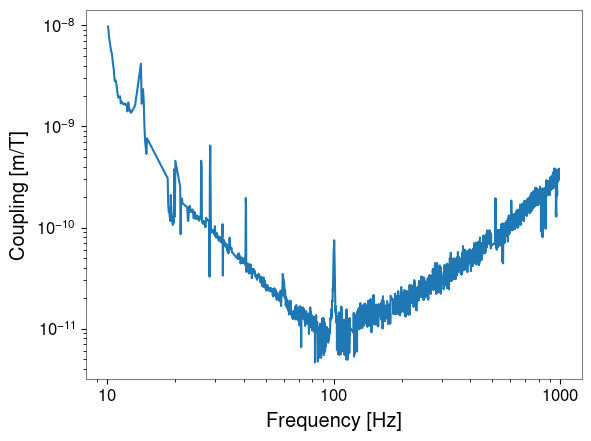

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plot = plt.figure()
ax = plot.gca()
ax.plot(fig7_dat['frequency'], np.abs(fig7_dat['factor']))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Coupling [m/T]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plot.show()

## Aplying the coupling function

This coupling function allows us to understand how much magnetic noise is present in the LIGO strain data. We arrive at the estimated noise contribution by multiplying the magnetic spectrum with the coupling function. 

In [9]:
strain_psd_h1 = strain_data_h1.psd(fftlength=fftlen)
strain_psd_l1 = strain_data_l1.psd(fftlength=fftlen)

In [10]:
from scipy.interpolate import interp1d
from gwpy.frequencyseries import FrequencySeries

coupling_func = interp1d(fig7_dat['frequency'], np.abs(fig7_dat['factor']), fill_value="extrapolate")
freqs = mag_data_l1.fft().frequencies.value
coupling_fs = FrequencySeries(coupling_func(freqs),
                              frequencies=freqs)

In [11]:
mag_filtered_l1 = (mag_data_l1.fft()*coupling_fs).ifft()
mag_filtered_h1 = (mag_data_h1.fft()*coupling_fs).ifft()

mag_psd_h1 = mag_filtered_h1.psd(fftlength=fftlen)
mag_psd_l1 = mag_filtered_l1.psd(fftlength=fftlen)

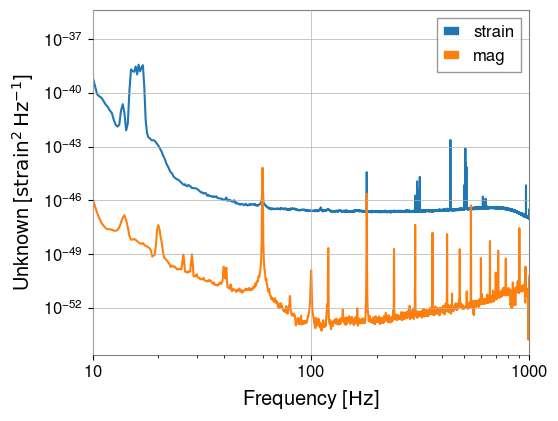

In [12]:
plot = (strain_psd_l1).plot(label='strain')
ax = plot.gca()
ax.plot(mag_psd_l1, label='mag')
ax.set_xlim(10, 1000)
#ax.set_ylim(1e-50, 1e-35)
ax.set_yscale('log')
ax.legend(loc='upper right')
plot.show()

Comparing the power spectral density from the strain data and the estimated magnetic noise contribution, we can see that magnetic noise is generally many orders of magnitude lower than other noise sources. For this reason, magnetic noise is not currently a problematic source of noise for most LIGO-Virgo-KAGRA analyses. 

The peaks in the magnetic noise power spectrum are related to the frequency (and harmonics) of the power grid in the United States. 

## Calculating the coherence

One analysis where magnetic noise may be problematic are stochastic searches for gravitational waves. In these analyses, we are looking for any correlations between detectors. Earth's magnetic field is one of the few known sources of noise that could cause correlations between our detectors (except for gravitational waves!). For this reason, stochastic analyses take extra precautions to ensure that magnetic noise is not biasing their analyses. 

To confirm that magnetic noise is not an issue for current analyses, we will calculate the coherence between the strain data from each observatory and compare this against the coherence between our estimate of the magnetic noise seen by each detector. 

In [13]:
strain_csd = strain_data_h1.csd(strain_data_l1, fftlength=fftlen)

mag_csd = mag_filtered_h1.csd(mag_filtered_l1, fftlength=fftlen)

In [14]:
strain_coh = np.abs(strain_csd)**2/(strain_psd_l1*strain_psd_h1)

mag_coh = np.abs(mag_csd)**2/(mag_psd_l1*mag_psd_h1)

In addition to the strain and magnetic coherences, we also can compare these results against the power spectrum from a single detector. In this case, we will choose LIGO Hanford. 

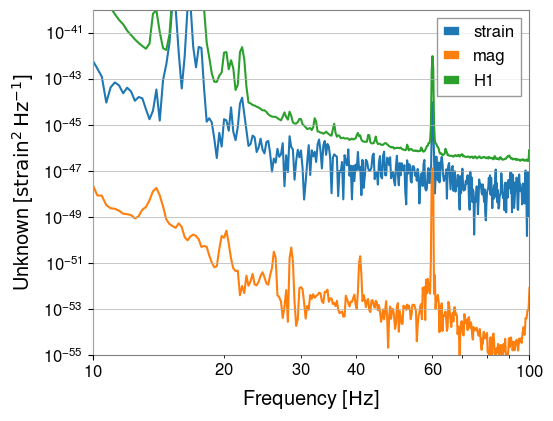

In [15]:
plot = (strain_psd_h1*strain_coh).plot(label='strain')
ax = plot.gca()
ax.plot(mag_psd_l1*mag_coh, label='mag')
ax.plot(strain_psd_h1, label='H1')
ax.set_xlim(10, 100)
ax.set_ylim(1e-55, 1e-40)
ax.set_yscale('log')
ax.legend(loc='upper right')
plot.show()

Looking at our plot, we can make a few observations:
* The amount of correlated strain noise (in blue) is lower than that of individual detectors. This is because most noise in each detector is uncorrelated with the other detector. Hence we can use data from multiple detectors to identify sources of correlated noise (and gravitational waves!) that would not be detectable with only one observatory. 
* The amount of correlated magnetic noise is still well below that of correlated strain noise (except at 60 Hz). Therefore magnetic noise is not biasing current searches for stochastic sources of gravitational waves. 

## Apply the overlap reduction function

As a final check, we can apply the *overlap reduction function* to our data. Since large distances separate the LIGO detectors, we don't expect the two data streams to be perfectly correlated, even if they see the same gravitational waves. The overlap reduction function models how correlated the two detectors should be for different frequencies of gravitational waves. 

Using the overlap reduction function, we can further check that magnetic noise does not limit our analyses. 

In [16]:
import lalsimulation

det1 = lalsimulation.DetectorPrefixToLALDetector('L1')
det2 = lalsimulation.DetectorPrefixToLALDetector('H1')

freqs = strain_coh.frequencies.value

det_overlap = np.array([lalsimulation.SimSGWBOverlapReductionFunction(float(f),det1,det2)
                   for f in freqs])
det_overlap[0] = 0.

det_overlap_fs = FrequencySeries(det_overlap,frequencies=freqs)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


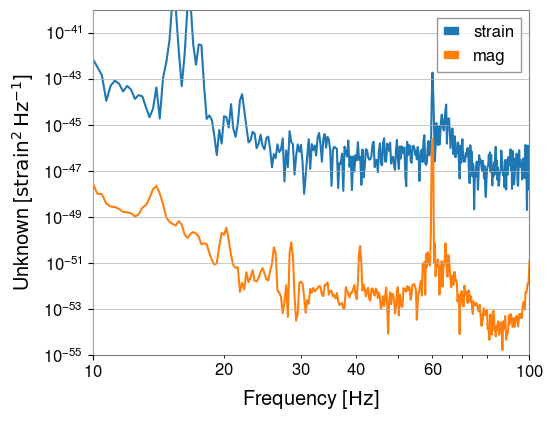

In [17]:
plot = (strain_psd_h1*strain_coh/abs(det_overlap_fs)).plot(label='strain')
ax = plot.gca()
ax.plot(mag_psd_l1*mag_coh/abs(det_overlap_fs), label='mag')
ax.set_xlim(10, 100)
ax.set_ylim(1e-55, 1e-40)
ax.set_yscale('log')
ax.legend(loc='upper right')
plot.show()

As expected, magnetic noise is still not a limiting source of nosie for current analyses!